In [ ]:
import warnings
warnings.filterwarnings('ignore')

# data imports
import pandas as pd
import numpy as np
from plotnine import *

# modeling imports
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV # Linear Regression Model
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder #Z-score variables
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error, accuracy_score #model evaluation
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, SplineTransformer #Z-score variables, Polynomial
from sklearn.model_selection import train_test_split #train-test-split model
from sklearn.mixture import GaussianMixture #GMM
import seaborn as sb #seaborn
import matplotlib.pyplot as plt #plot
from sklearn.decomposition import PCA #PCA
from sklearn.cluster import KMeans #k-means
from sklearn.metrics import silhouette_score #silhoutte score

# pipeline imports
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer

#other imports
import random #random

%matplotlib inline

In [ ]:
data = pd.read_csv("/content/kindle_data-v2.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133102 entries, 0 to 133101
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   asin               133102 non-null  object 
 1   title              133102 non-null  object 
 2   author             132677 non-null  object 
 3   soldBy             123869 non-null  object 
 4   imgUrl             133102 non-null  object 
 5   productURL         133102 non-null  object 
 6   stars              133102 non-null  float64
 7   reviews            133102 non-null  int64  
 8   price              133102 non-null  float64
 9   isKindleUnlimited  133102 non-null  bool   
 10  category_id        133102 non-null  int64  
 11  isBestSeller       133102 non-null  bool   
 12  isEditorsPick      133102 non-null  bool   
 13  isGoodReadsChoice  133102 non-null  bool   
 14  publishedDate      84086 non-null   object 
 15  category_name      133102 non-null  object 
dtypes:

In [ ]:
#checking for missing data
data.isnull().sum()

asin                     0
title                    0
author                 425
soldBy                9233
imgUrl                   0
productURL               0
stars                    0
reviews                  0
price                    0
isKindleUnlimited        0
category_id              0
isBestSeller             0
isEditorsPick            0
isGoodReadsChoice        0
publishedDate        49016
category_name            0
dtype: int64

In [ ]:
#dropping missing data and resetting indices
data.dropna(inplace = True)
data.reset_index(inplace = True)

In [ ]:
#fixing date data

data['publishedDate'] = pd.to_datetime(data['publishedDate'])

data['publishedDate'] = data['publishedDate'].apply(lambda x: x.timestamp())

In [ ]:
# Store MAE scores for each model
mae_scores = []

#setting X and Y
predictors = ["reviews", "price", "isKindleUnlimited", "isBestSeller", "isEditorsPick", "isGoodReadsChoice", "publishedDate", "category_id"]

X = data[predictors]
Y = data["stars"]

#train test split with 80/20 split
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2)

#z-scoring, OneHotEncoding
continuous = ["reviews", "price", "publishedDate"]
categorical = ["isKindleUnlimited", "isBestSeller", "isEditorsPick", "isGoodReadsChoice", "category_id"]

preprocess = make_column_transformer((StandardScaler(), continuous),
                            (OneHotEncoder(), categorical),
                            remainder = "passthrough")

lr = LinearRegression()

#Linear model

linearPipe = Pipeline([("pre", preprocess),
                ("linearregression", lr)])

#fit
linearPipe.fit(x_train, y_train)

#predict
y_pred_train = linearPipe.predict(x_train)
y_pred_test = linearPipe.predict(x_test)

print("Test MAE  : ", mean_absolute_error(y_test,y_pred_test))

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred_test)
# Store MAE for this model
mae_scores.append(("none", mae))

Test MAE  :  0.3837765033151192


In [ ]:
# Iterate over each predictor
for predictor_to_exclude in predictors:
    # Exclude the current predictor
    predictors_subset = [p for p in predictors if p != predictor_to_exclude]

    # Define preprocess pipeline for this iteration
    preprocess = make_column_transformer(
        (StandardScaler(), [col for col in predictors_subset if col in continuous]),
        (OneHotEncoder(handle_unknown='ignore'), [col for col in predictors_subset if col in categorical]),
        remainder="passthrough"
    )

    # Define the pipeline for this iteration
    pipeline = Pipeline([
        ("pre", preprocess),
        ("linearregression", lr)
    ])

    # Fit the model
    pipeline.fit(x_train, y_train)

    # Predict
    y_pred_test = pipeline.predict(x_test)

    # Calculate MAE
    mae = mean_absolute_error(y_test, y_pred_test)

    # Store MAE for this model
    mae_scores.append((predictor_to_exclude, mae))

# Print MAE scores for each model
for predictor, mae in mae_scores:
    print(f"MAE without {predictor}: {mae}")

MAE without none: 0.3837765033151192
MAE without reviews: 0.3856532214456925
MAE without price: 0.3837805236180105
MAE without isKindleUnlimited: 0.38377659835674827
MAE without isBestSeller: 0.38377578635348286
MAE without isEditorsPick: 0.3837770732005738
MAE without isGoodReadsChoice: 0.383776390502514
MAE without publishedDate: 0.389205158737486
MAE without category_id: 0.38939903098315504


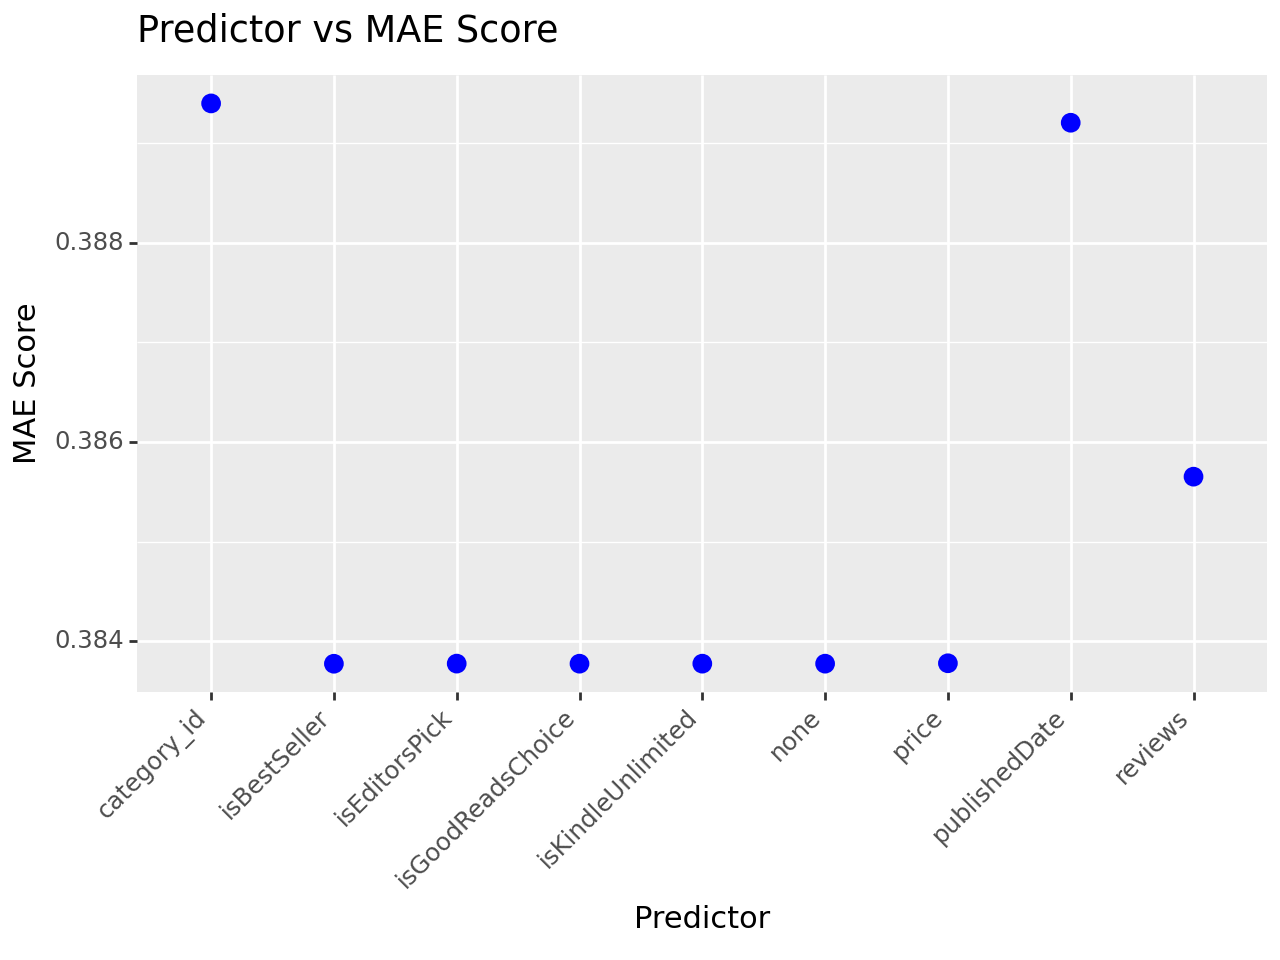

In [ ]:
# Convert mae_scores to a DataFrame
mae_df = pd.DataFrame(mae_scores, columns=['predictor', 'MAE'])

# Plot the graph with points
p = ggplot(mae_df, aes(x='predictor', y='MAE')) + \
    geom_point(color='blue', size=3) + \
    theme(axis_text_x=element_text(rotation=45, hjust=1)) + \
    labs(title='Predictor vs MAE Score', x='Predictor', y='MAE Score')

# Show the plot
print(p)

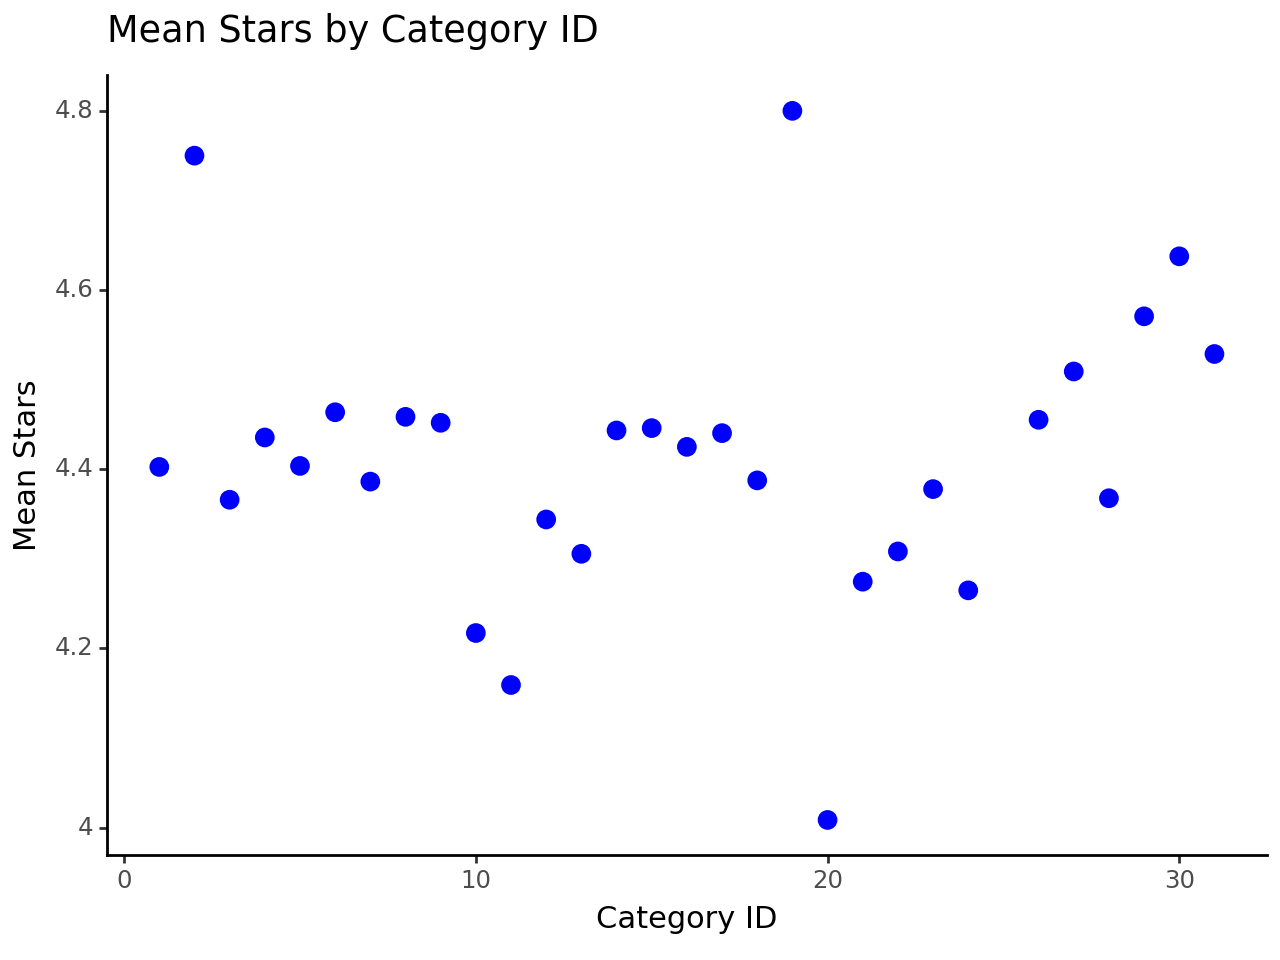


    category_id                 category_name     stars
0             1           Arts & Photo graphy  4.402595
1             2                        Comics  4.750000
2             3          Education & Teaching  4.365979
3             4                       History  4.435477
4             5          Literature & Fiction  4.403717
5             6     Parenting & Relationships  4.463634
6             7                       Romance  4.386234
7             8             Sports & Outdoors  4.458496
8             9         Biographies & Memoirs  4.451877
9            10        Computers & Technology  4.217248
10           11  Engineering & Transportation  4.159218
11           12         Humor & Entertainment  4.343986
12           13                       Medical  4.305643
13           14    Politics & Social Sciences  4.443327
14           15                Science & Math  4.445928
15           16            Teen & Young Adult  4.425000
16           17              Business & Money  

In [ ]:
# Calculate mean stars for each category
mean_stars = data.groupby('category_id')['stars'].mean().reset_index()

# Plotting the graph with mean values
p = ggplot(mean_stars, aes(x='category_id', y='stars')) + \
    geom_point(color='blue', size=3) + \
    theme_classic() + \
    labs(title='Mean Stars by Category ID', x='Category ID', y='Mean Stars')

# Show the plot
print(p)

# Merge grouped_data and mean_stars on 'category_id'
grouped_data = data.groupby('category_id').first().reset_index()
merged_data = pd.merge(grouped_data[['category_id', 'category_name']], mean_stars[['category_id', 'stars']], on='category_id')

# Print out the merged data
print(merged_data)

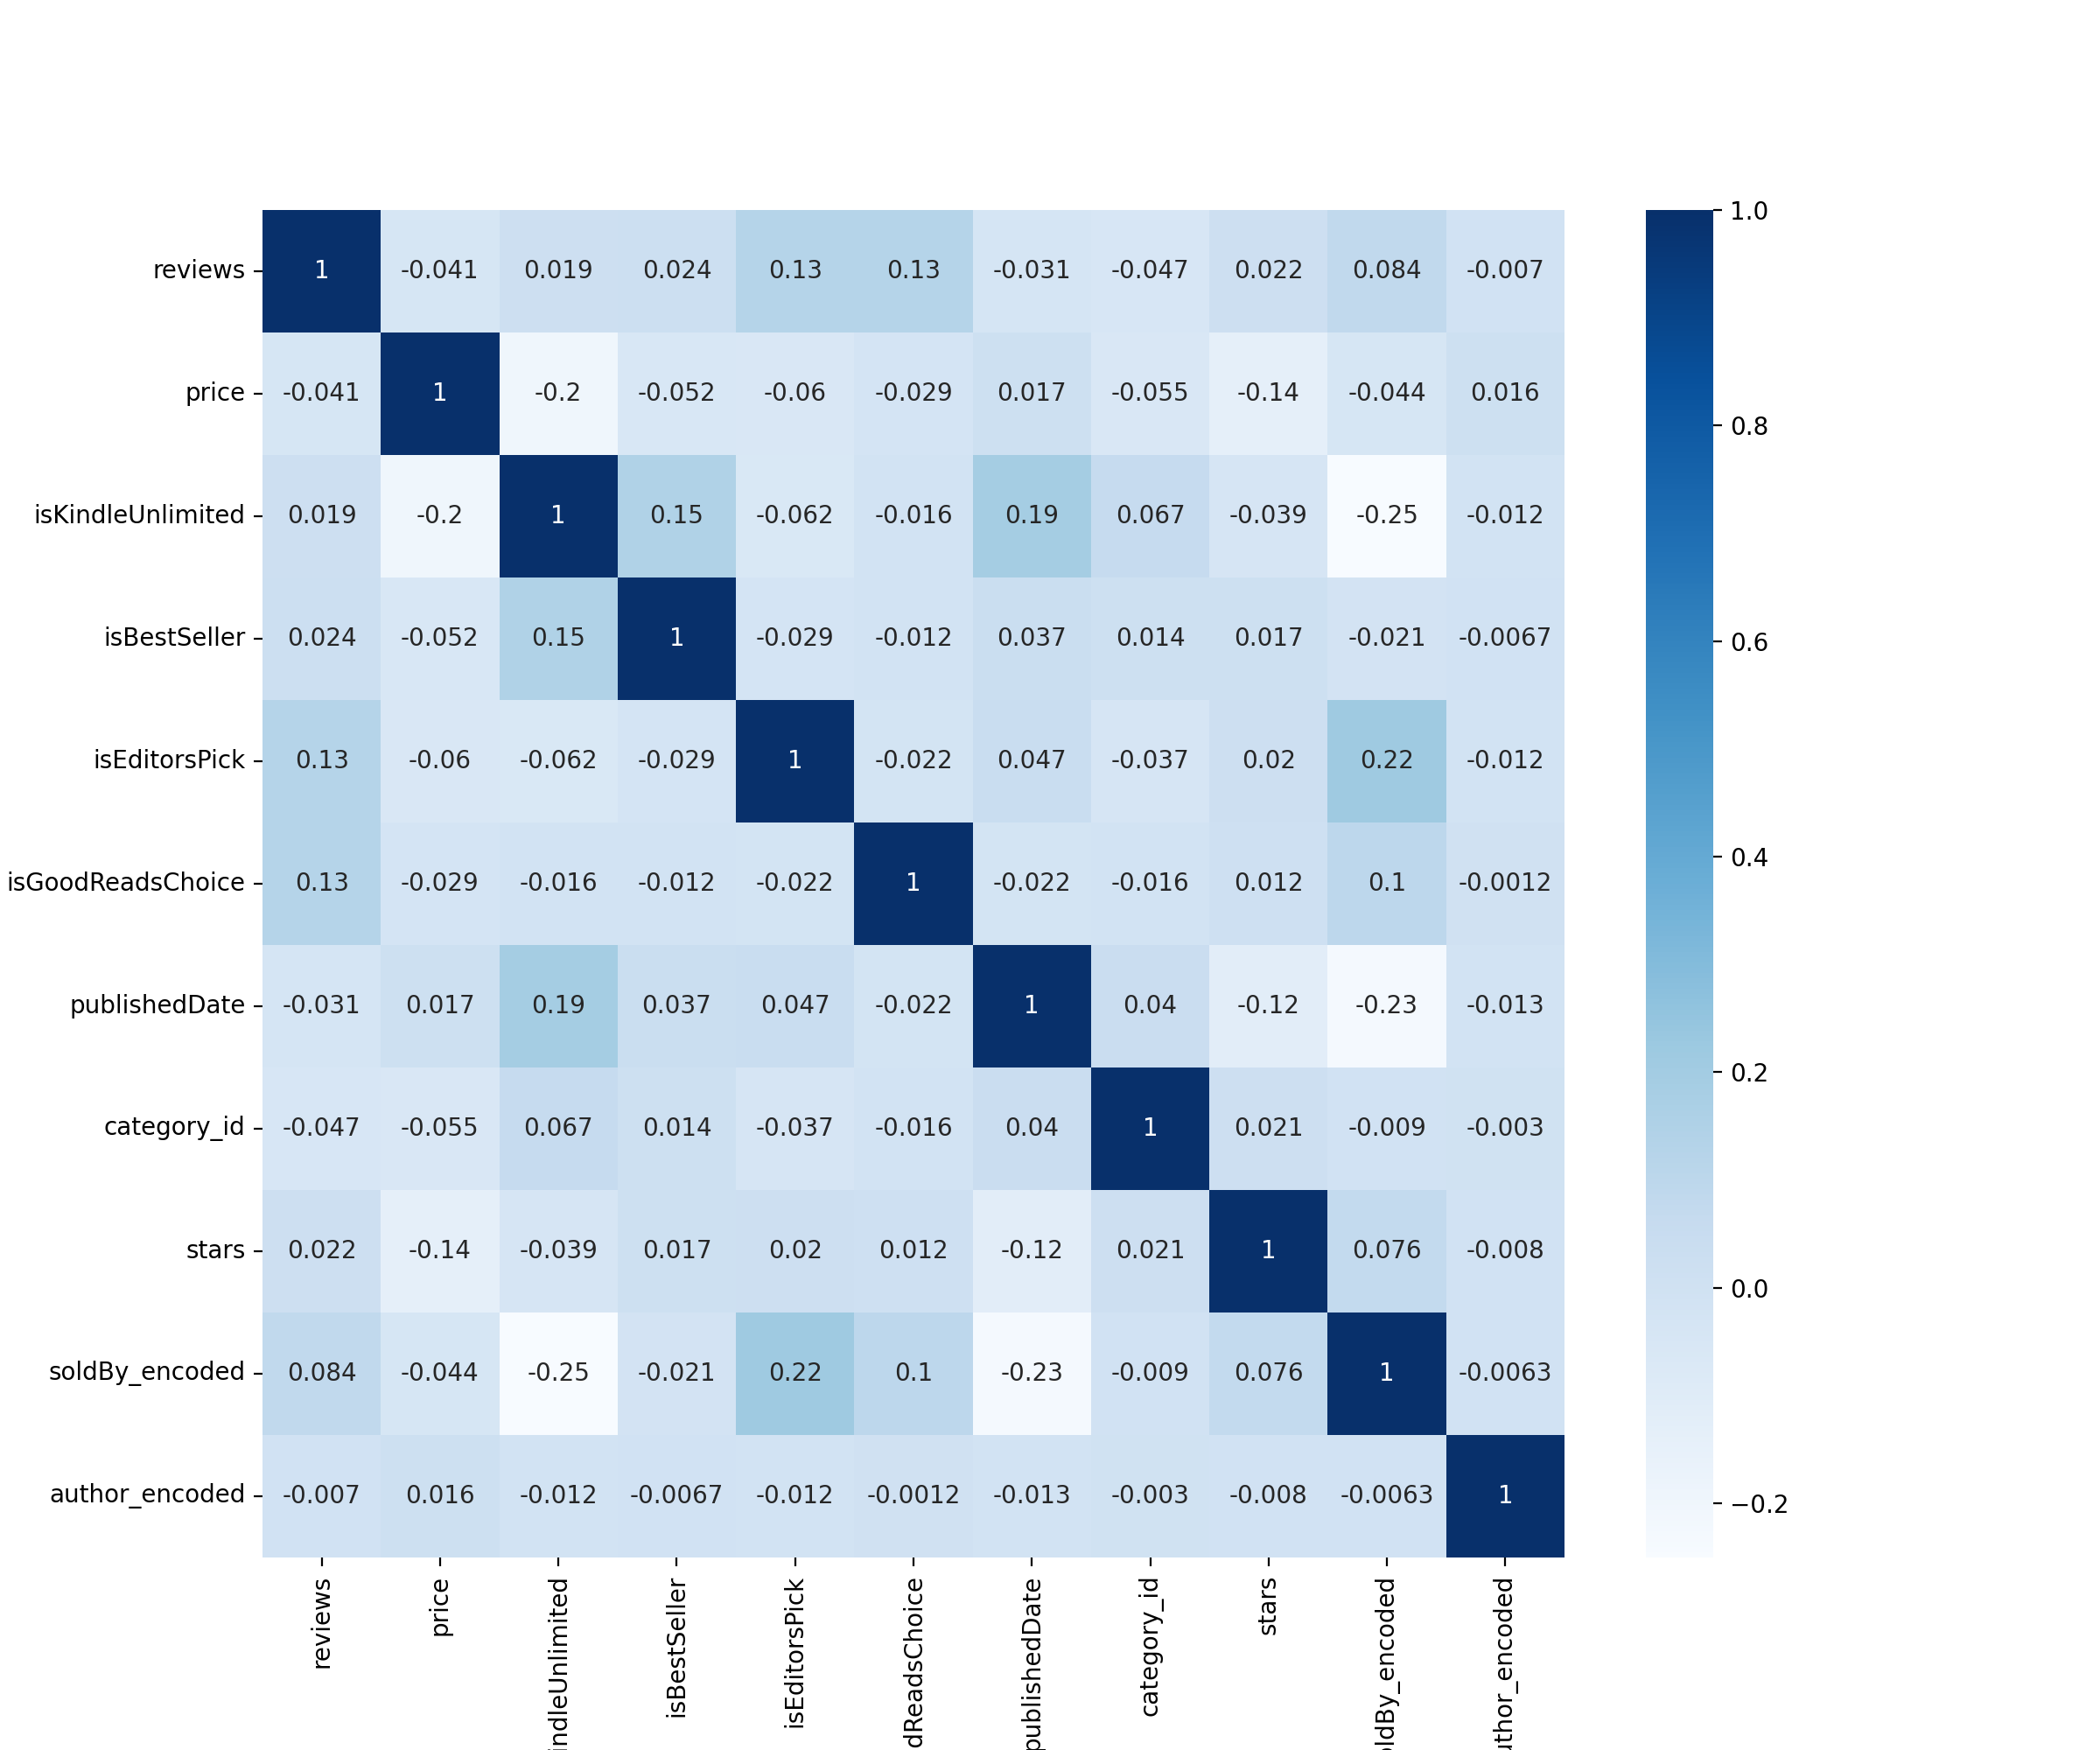

In [ ]:
#adjusting data
newPredictors = ["reviews", "price", "isKindleUnlimited", "isBestSeller", "isEditorsPick", "isGoodReadsChoice", "publishedDate", "category_id", "stars"]
newData = data[newPredictors]

#encoding string data
label_encoder = LabelEncoder()
newData['soldBy_encoded'] = label_encoder.fit_transform(data['soldBy'])
newData['author_encoded'] = label_encoder.fit_transform(data['author'])

#heatmap
plt.figure(figsize=(12, 10))
sb.heatmap(newData.corr(), cmap="Blues", annot=True)
plt.show()

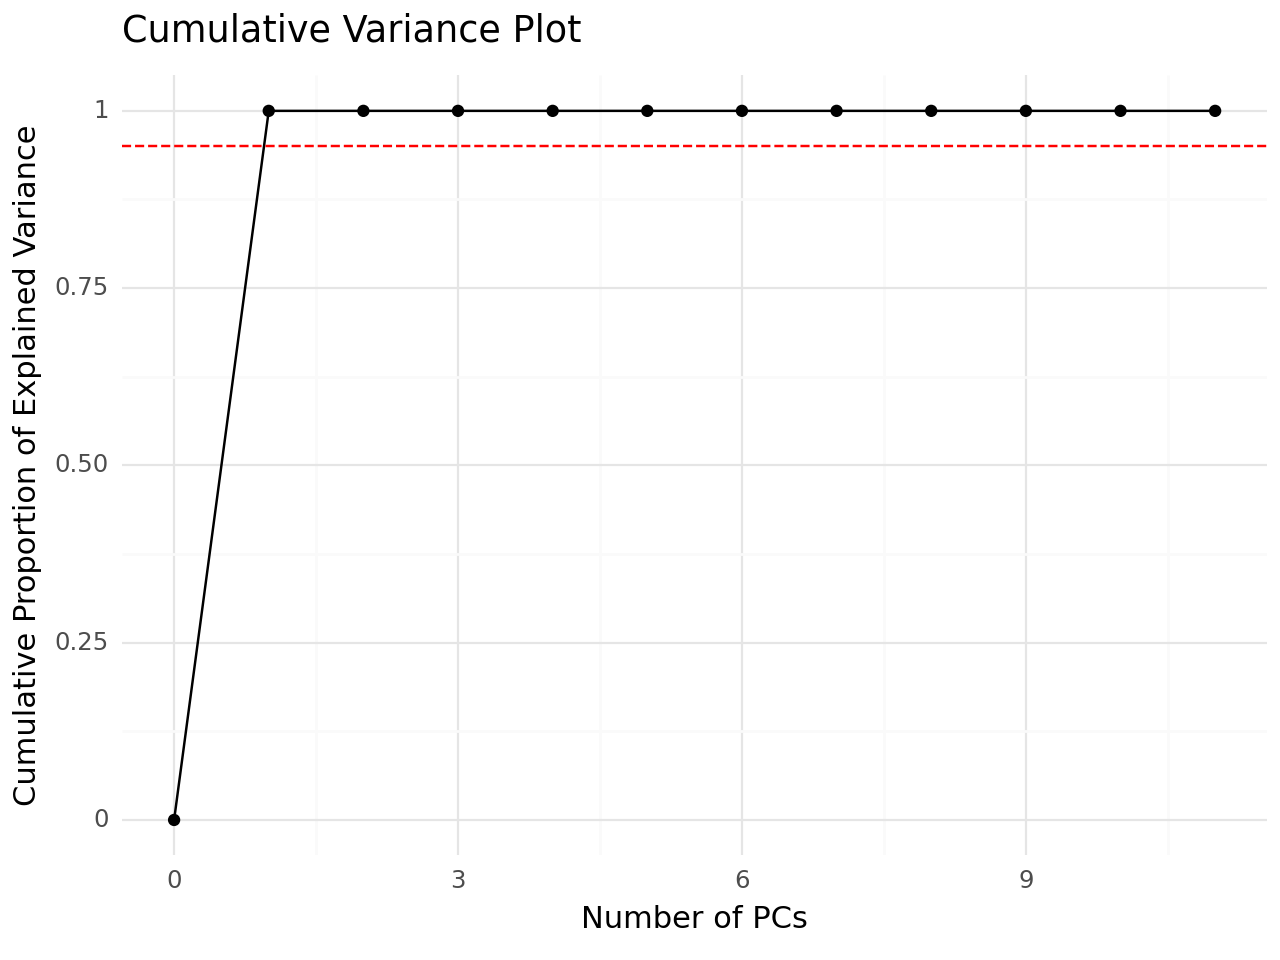

In [ ]:
#PCA

# empty pipeline
z = make_column_transformer((StandardScaler(), newPredictors),
                            remainder = "passthrough")

pca = PCA()

pipe_PCA = Pipeline([
    ("z", z),
    ("pca", pca)
])

# fit
pipe_PCA.fit(newData)

# scree/cumvar plot
num_components = len(pipe_PCA.named_steps["pca"].explained_variance_ratio_)
pcaDF = pd.DataFrame({
    "expl_var": pipe_PCA.named_steps["pca"].explained_variance_ratio_,
    "pc": range(1, num_components + 1),
    "cum_var": pipe_PCA.named_steps["pca"].explained_variance_ratio_.cumsum()
})

# cumulative variance
pcaDF0 = pd.concat([pcaDF, pd.DataFrame({"pc": [0], "cum_var": [0]})])

print(ggplot(pcaDF0, aes(x = "pc", y = "cum_var")) + geom_line() +
 geom_point() + geom_hline(yintercept = 0.95, color = "red", linetype = "dashed") +
 theme_minimal() + labs(x = "Number of PCs", y = "Cumulative Proportion of Explained Variance", title = "Cumulative Variance Plot"))

completed2
completed3
completed4
completed5
completed6
completed7
completed8
completed9
completed10
completed11
completed12
completed13
completed14
completed15
completed16
completed17
completed18
completed19


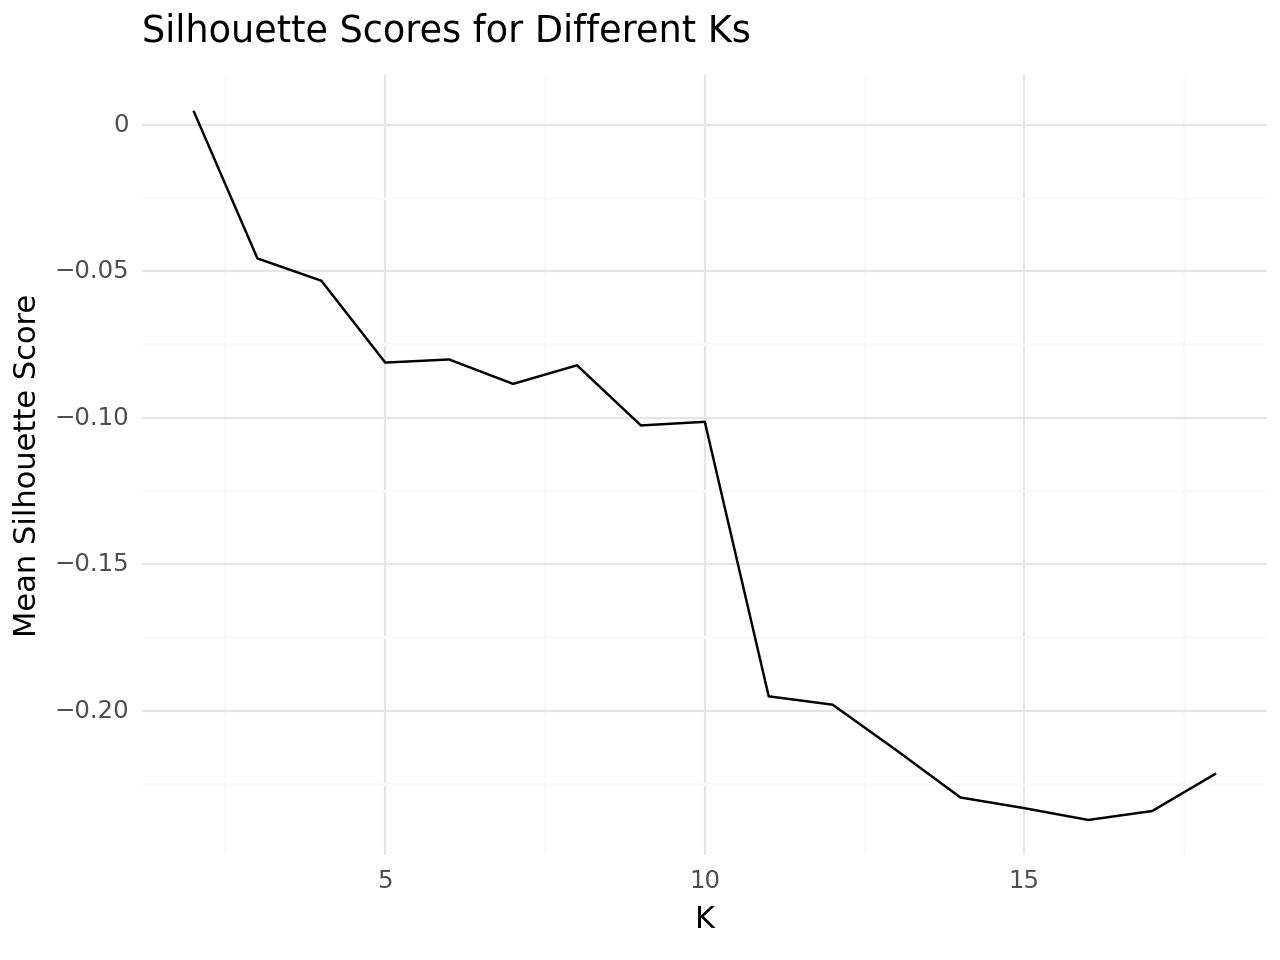

In [ ]:
sample_size = 1000

# Take a random sample from newData
random.seed(42)
sampled_data = newData.sample(n=sample_size)

metrics = {"sil": [], "k": []}

for i in range(2,20):
    km = KMeans(i)
    pipe = Pipeline([
        ("pre", z),
        ("km", km)
    ])

    labels = pipe.fit_predict(sampled_data)
    sil = silhouette_score(sampled_data, labels)

    df = pd.DataFrame(metrics)

    metrics["sil"].append(sil)
    metrics["k"].append(i)

    print("completed" + str(i))

print(ggplot(df, aes(x = "k", y = "sil")) +
  geom_line() + theme_minimal() +
    labs(x = "K", y = "Mean Silhouette Score",
         title = "Silhouette Scores for Different Ks"))

In [ ]:
#KMeans with the best number of clusters

km = KMeans(2)
kPipe = Pipeline([
      ("pre", z),
      ("km", km)
])
kLabels = kPipe.fit_predict(newData)

sil = silhouette_score(newData, kLabels)

newData["clusters"] = kLabels

print("Silhoutte Score: " + str(sil))

Silhoutte Score: 1.4092701805596677e-05


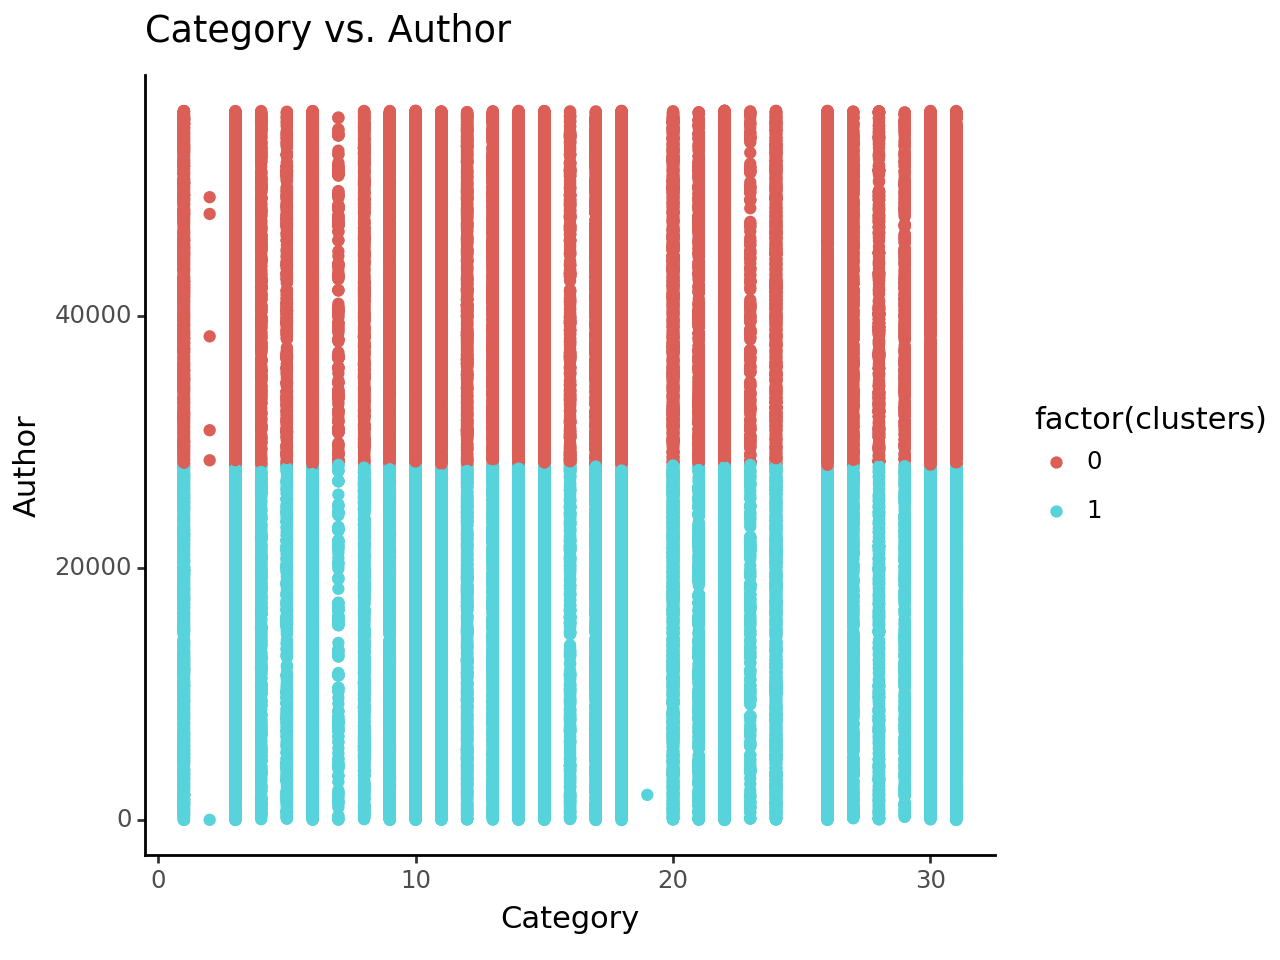

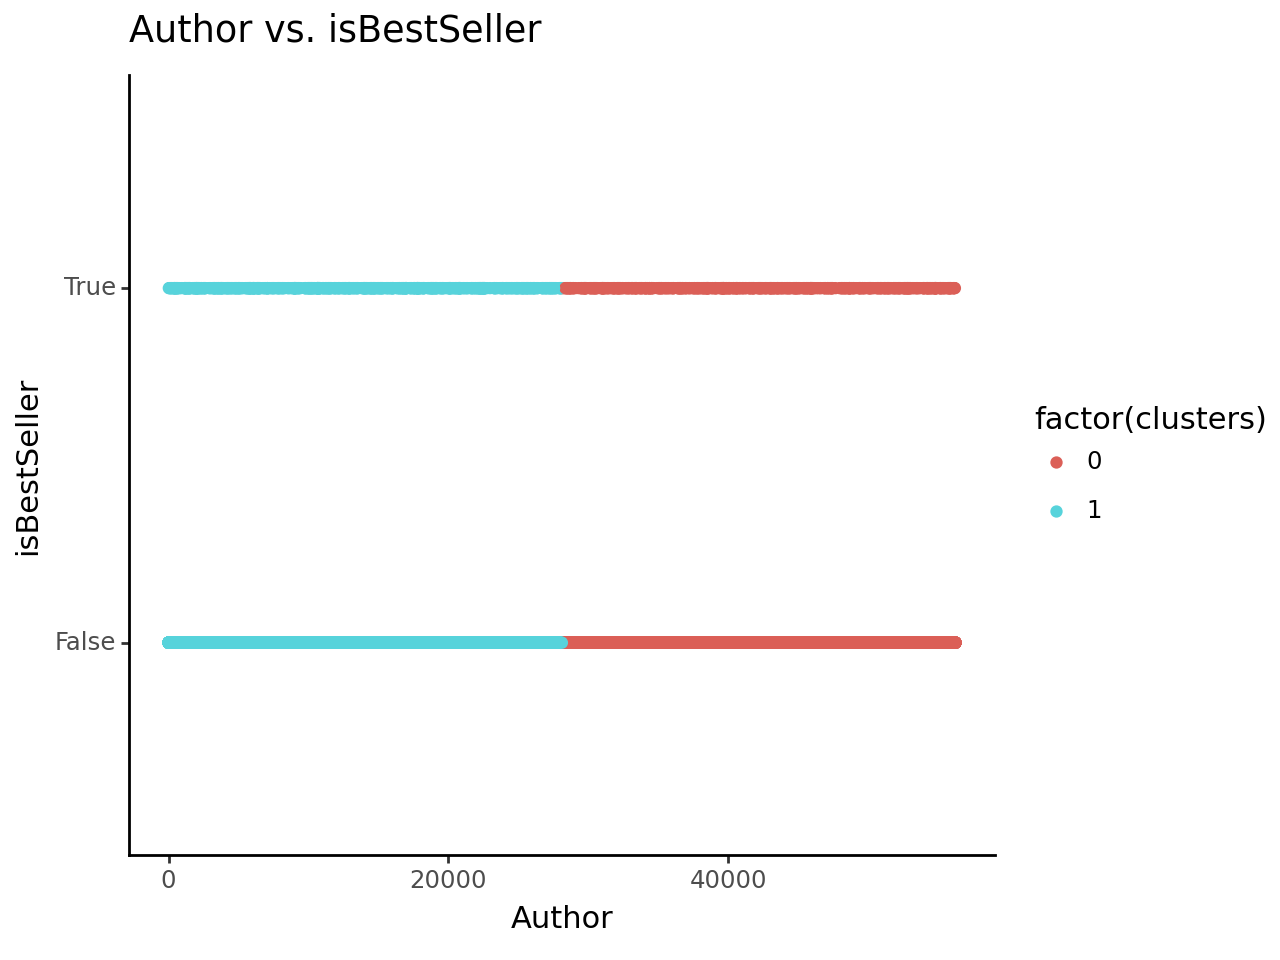

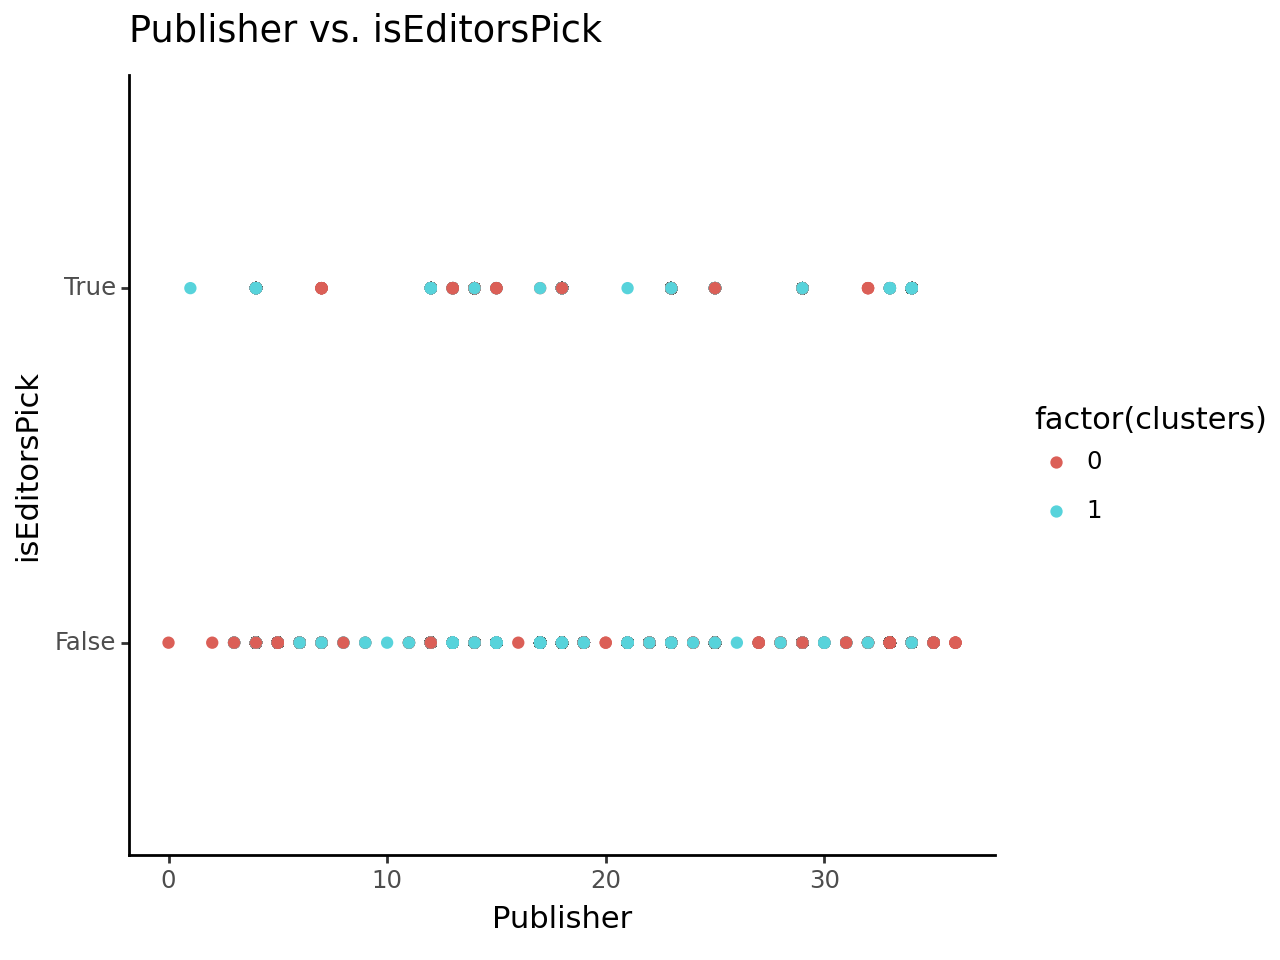

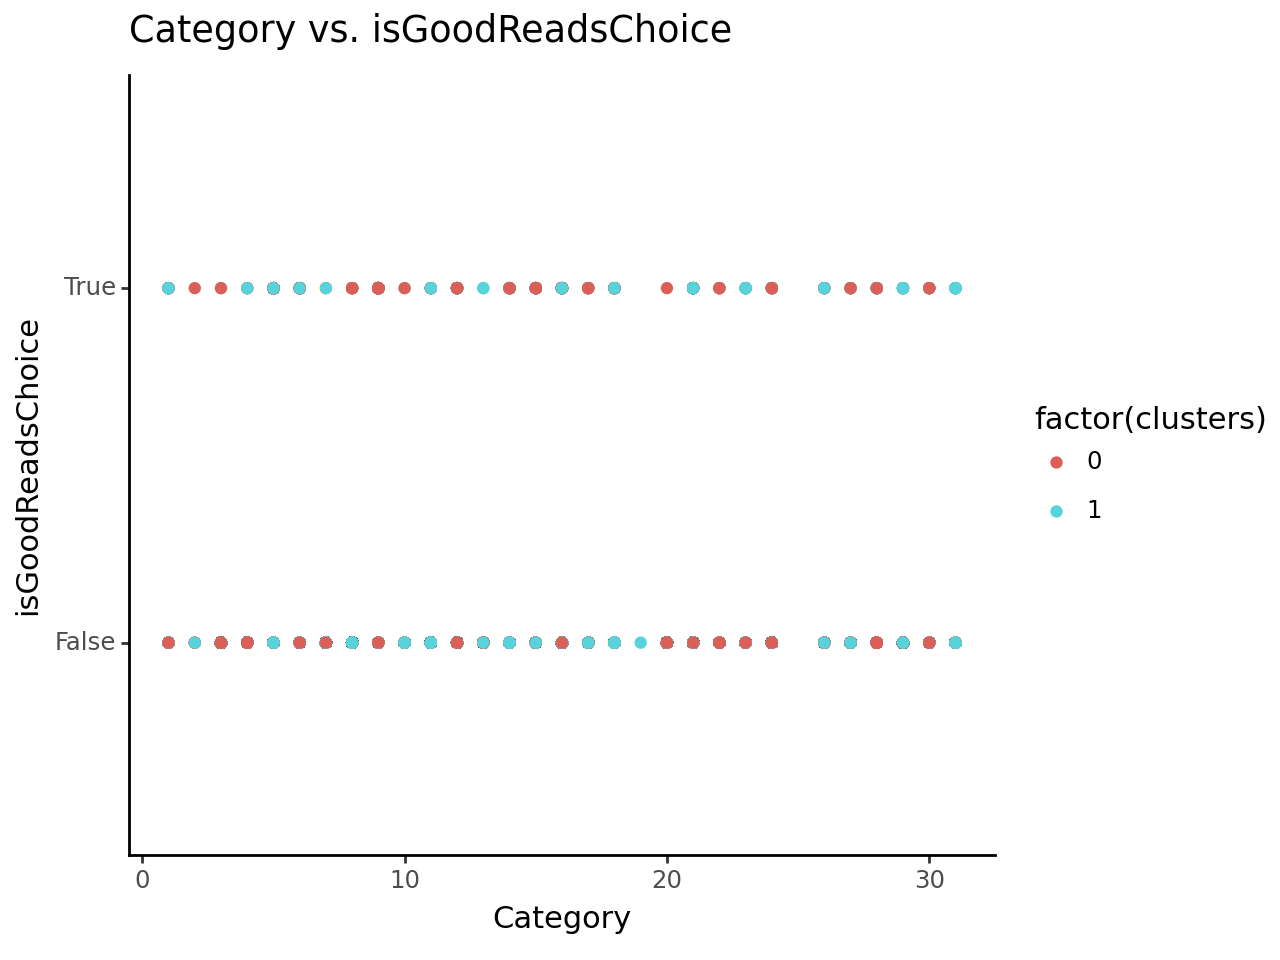

In [ ]:
#Graphs

print(ggplot(newData, aes(x = "category_id", y = "author_encoded", color = "factor(clusters)")) + geom_point() +
 labs(x = "Category", y = "Author", title = "Category vs. Author") +
  theme_classic())

print(ggplot(newData, aes(x = "author_encoded", y = "isBestSeller", color = "factor(clusters)")) + geom_point() +
 labs(x = "Author", y = "isBestSeller", title = "Author vs. isBestSeller") +
  theme_classic())

print(ggplot(newData, aes(x = "soldBy_encoded", y = "isEditorsPick", color = "factor(clusters)")) + geom_point() +
 labs(x = "Publisher", y = "isEditorsPick", title = "Publisher vs. isEditorsPick") +
  theme_classic())

print(ggplot(newData, aes(x = "category_id", y = "isGoodReadsChoice", color = "factor(clusters)")) + geom_point() +
 labs(x = "Category", y = "isGoodReadsChoice", title = "Category vs. isGoodReadsChoice") +
  theme_classic())

In [ ]:
#plotting average of each predictor by cluster.

newData.groupby(kLabels).mean()

,reviews,price,isKindleUnlimited,isBestSeller,isEditorsPick,isGoodReadsChoice,publishedDate,category_id,stars,soldBy_encoded,author_encoded,clusters
0,628.492823,19.492879,0.157791,0.015595,0.046786,0.009311,1.522357e+09,15.167878,4.363631,10.385749,42276.397259,0.0
1,669.214233,19.235822,0.153290,0.016839,0.049828,0.008995,1.519188e+09,15.143861,4.378983,10.530778,14082.322525,1.0


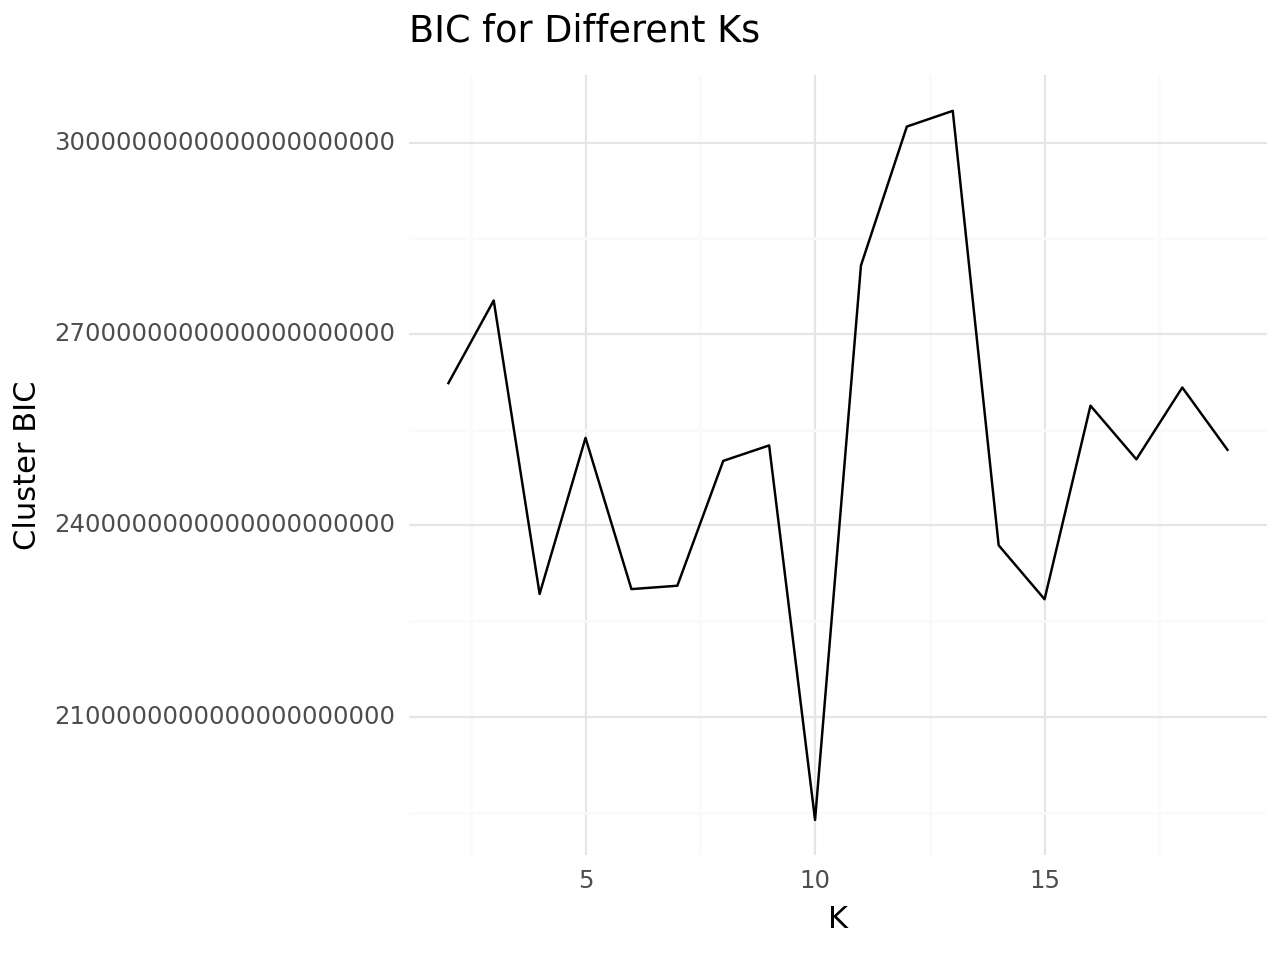

In [ ]:
#GMM

metrics = {"BIC": [], "k": []}

for i in range(2,20):
    gmm = GaussianMixture(i)
    pipe = Pipeline([
        ("pre", z),
        ("gmm", gmm)
    ])

    labels = pipe.fit_predict(sampled_data)
    bic_val = pipe.named_steps["gmm"].bic(sampled_data)

    metrics["BIC"].append(bic_val)
    metrics["k"].append(i)

df = pd.DataFrame(metrics)

print(ggplot(df, aes(x = "k", y = "BIC")) +
  geom_line() + theme_minimal() +
    labs(x = "K", y = "Cluster BIC",
         title = "BIC for Different Ks"))

In [ ]:
#GMM with k = 13

gmm = GaussianMixture(13)
pipe = Pipeline([
      ("pre", z),
      ("gmm", gmm)
])
labels = pipe.fit_predict(newData)

bic_val = pipe.named_steps["gmm"].bic(newData)

newData["GMMClusters"] = labels

print("BIC: " + str(bic_val));

BIC: 6.892741841927095e+22


In [ ]:
newData.groupby(labels).mean()

,reviews,price,isKindleUnlimited,isBestSeller,isEditorsPick,isGoodReadsChoice,publishedDate,category_id,stars,soldBy_encoded,author_encoded,GMMClusters
0,98877.200000,7.240000,0.500000,0.45,0.000000,0.55,1.499636e+09,8.150000,4.530000,14.050000,28890.850000,0.0
1,794.123255,6.561841,1.000000,0.00,0.000000,0.00,1.590410e+09,17.600426,4.447504,4.000000,28003.082091,1.0
2,5417.209700,11.479643,0.094151,0.00,0.000000,1.00,1.481123e+09,13.894437,4.472611,20.523538,27910.517832,2.0
3,19432.095032,13.475616,0.544276,0.00,0.546436,0.00,1.466955e+09,12.014039,4.421598,15.979482,27379.023758,3.0
4,1274.119589,11.495270,0.000000,0.00,0.000000,0.00,1.445012e+09,17.816944,4.566787,17.891773,28352.322527,4.0
5,1.137663,52.239626,0.233322,0.00,0.000000,0.00,1.564154e+09,15.412284,3.310095,16.369926,28219.750441,5.0
6,1786.427813,12.317573,0.000000,0.00,0.908405,0.00,1.544820e+09,14.047194,4.458196,19.902820,27333.684725,6.0
7,352.632850,7.475459,0.729469,1.00,0.000000,0.00,1.602713e+09,16.235507,4.475725,4.000000,26964.031401,7.0
8,127.463960,23.414399,0.045153,0.00,0.000000,0.00,1.391291e+09,10.606255,4.445423,20.607291,27793.437241,8.0
9,0.196955,77.277630,0.000000,0.00,0.000000,0.00,1.606601e+09,15.189672,1.793843,4.116187,28899.168487,9.0


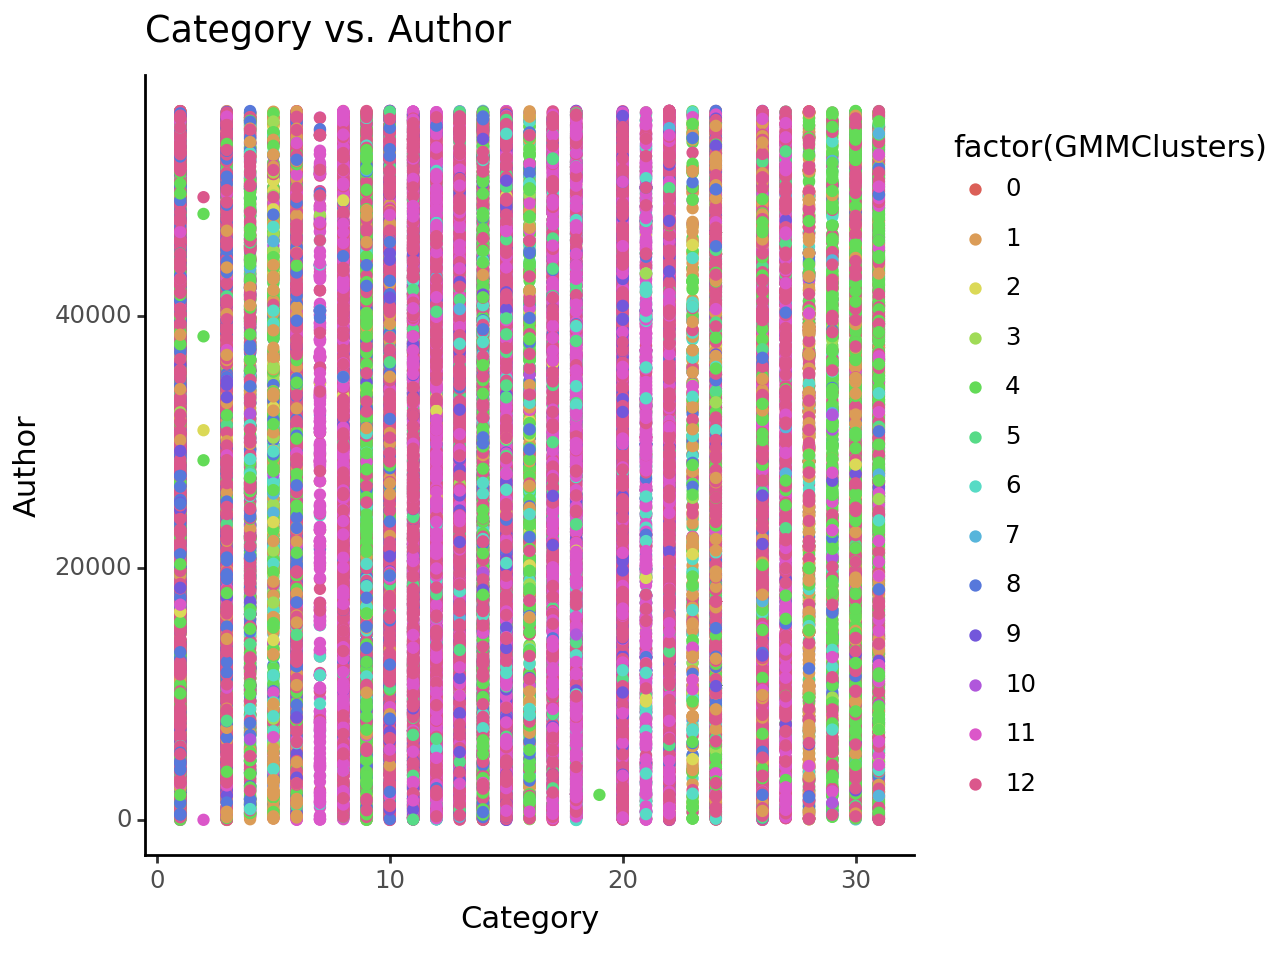

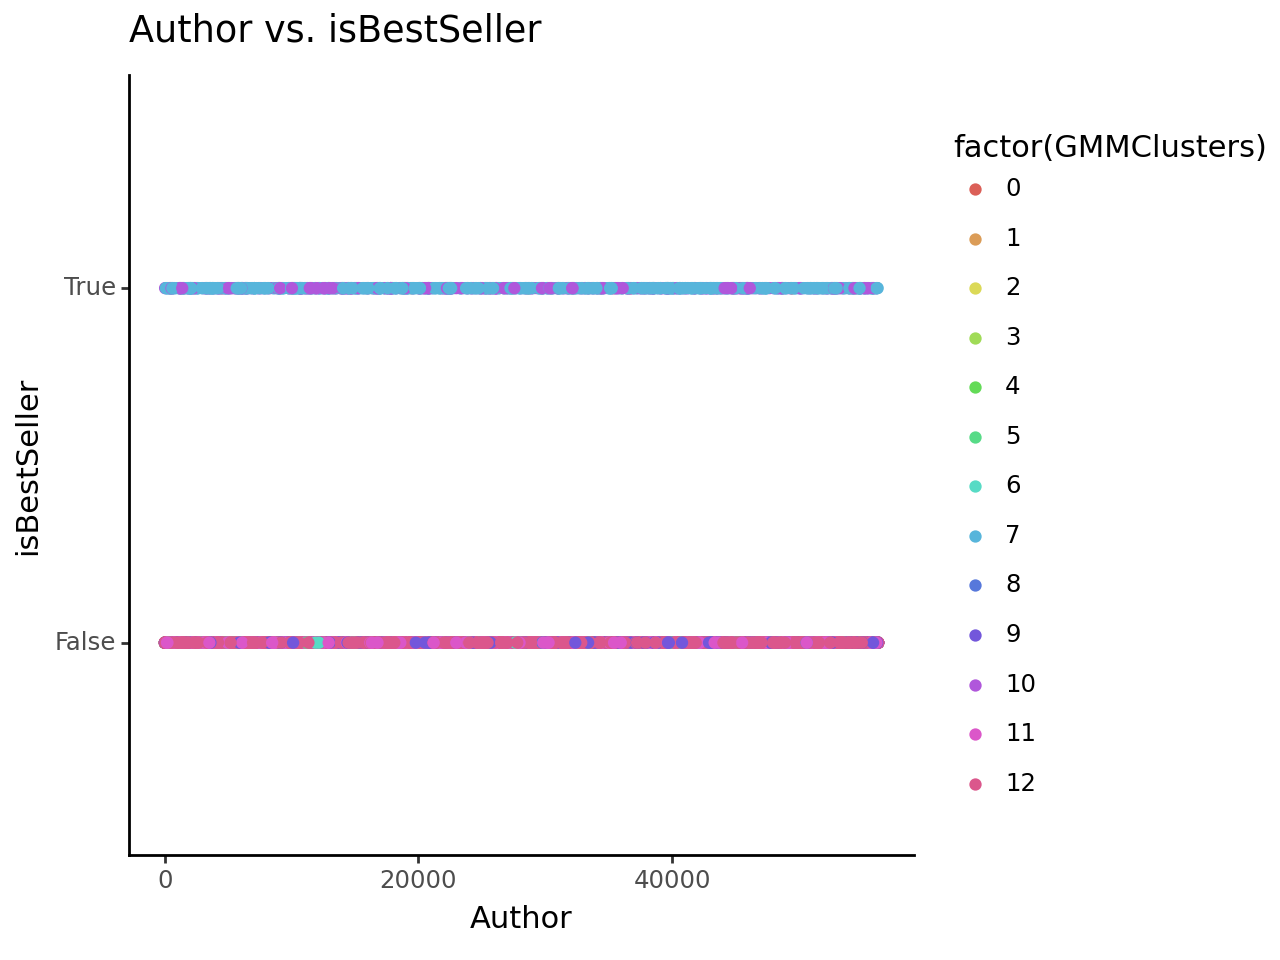

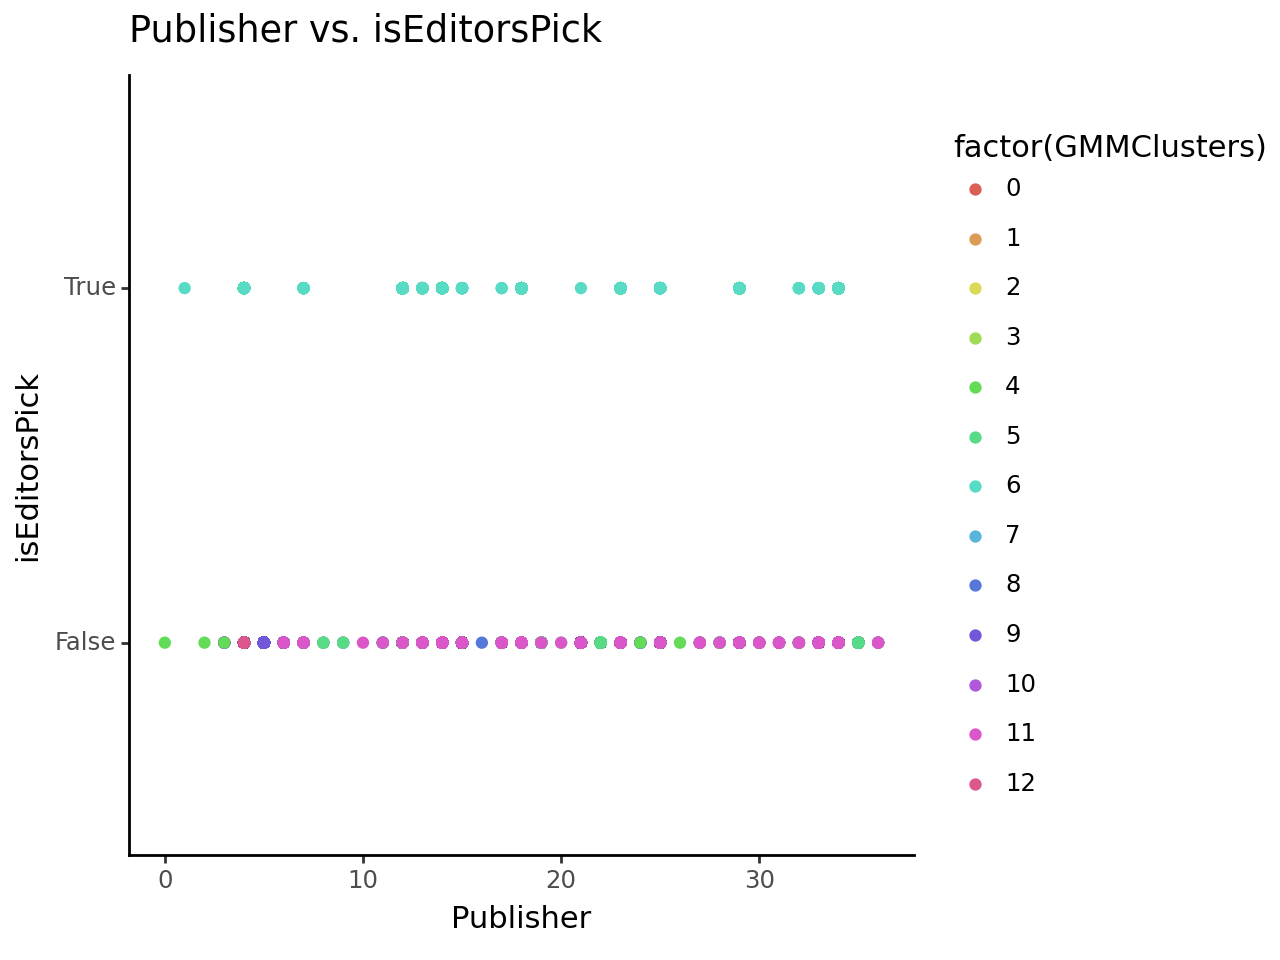

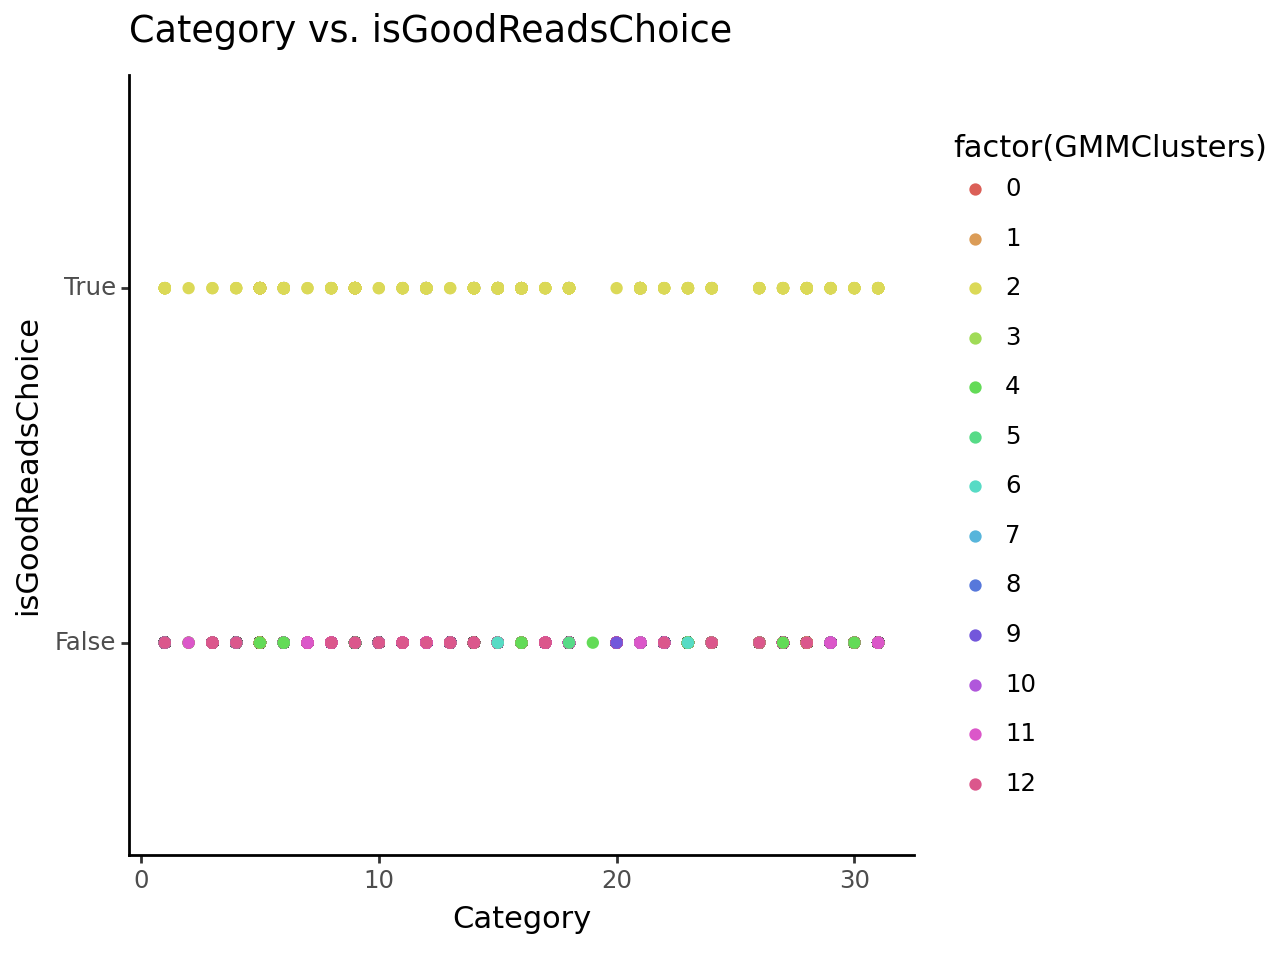

In [ ]:
print(ggplot(newData, aes(x = "category_id", y = "author_encoded", color = "factor(GMMClusters)")) + geom_point() +
 labs(x = "Category", y = "Author", title = "Category vs. Author") +
  theme_classic())

print(ggplot(newData, aes(x = "author_encoded", y = "isBestSeller", color = "factor(GMMClusters)")) + geom_point() +
 labs(x = "Author", y = "isBestSeller", title = "Author vs. isBestSeller") +
  theme_classic())

print(ggplot(newData, aes(x = "soldBy_encoded", y = "isEditorsPick", color = "factor(GMMClusters)")) + geom_point() +
 labs(x = "Publisher", y = "isEditorsPick", title = "Publisher vs. isEditorsPick") +
  theme_classic())

print(ggplot(newData, aes(x = "category_id", y = "isGoodReadsChoice", color = "factor(GMMClusters)")) + geom_point() +
 labs(x = "Category", y = "isGoodReadsChoice", title = "Category vs. isGoodReadsChoice") +
  theme_classic())